# 1. Import

In [1]:
# Data Wrangling
import pandas as pd
import numpy as np
import gc

# Visualization, EDA
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# Korean font
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#rc('font', family=font_name)

# Preprocessing & Feature Engineering
from sklearn.preprocessing import LabelEncoder

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Utility
import re
import os
import time
import datetime
import random
import tensorflow as tf
import pickle
import joblib
import platform
import warnings; warnings.filterwarnings("ignore")

In [2]:
# 코랩에서만 결로 설정
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
gc.collect()

62

# 2. Read Data

In [4]:
# 주피터 파일일때(주석처리)
panel = pd.read_csv(os.path.abspath("../input") + '/panel.csv')
survey = pd.read_csv(os.path.abspath("../input") + '/survey.csv')
response_train = pd.read_csv(os.path.abspath("../input") + '/response_train.csv')
response_test = pd.read_csv(os.path.abspath("../input") + '/response_test.csv')

# 성별, 지역 값이 Nan 값인 패널 1명 test에도 존재 하지 않아 그냥 drop
panel.drop(8315, axis=0, inplace=True)
# REGION 컬럼 무의미해서 drop
panel.drop(['REGION'], axis=1, inplace=True)

# 3. Feature Create

##### (패널 질문 응답수)

In [5]:
# 패널 질문 COUNT(질문의 성의 판단)
panel_Questions = panel.iloc[:,4:]

panel = panel.iloc[:,:4]
panel_Questions_count = []
for i in range(panel_Questions.shape[0]):
            panel_Questions_count.append(pd.notna(panel_Questions.iloc[i,:].values).sum())

# 패널 질문 응답수
panel['Questions_count'] = panel_Questions_count

#survey['IR_r'] = survey.IR.replace({0: 0.9})

#survey['IR_CPI'] = survey.CPI/survey.IR_r
#survey['LOI_CPI'] = survey.CPI/survey.LOI

train = response_train.merge(panel).merge(survey)
test = response_test.merge(panel).merge(survey).sort_values(by='ID')

In [6]:
# train 데이터 분할
before_train = train.query("TIME<='2021-02-01 00:00:00'")
train = train.query("TIME>='2021-02-01 00:00:00'")

##### (패널 ID별 누적 포인트)

In [7]:
# 패널 ID 별 획득 누적 포인트
Points_earned = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned',np.sum)])).reset_index()

train = train.merge(Points_earned, how='left')
train['Points_earned'].fillna(0, inplace = True)
test = test.merge(Points_earned, how='left')
test['Points_earned'].fillna(0, inplace = True)

##### (일자, 요일, 시간, 시간별 범위, 시간 범위별 응답확률), (리워드 포인트별 범위, 리워드 범위별 응답 확률)

In [8]:
data = [train, test]

for i in data:
    i['TIME'] = i['TIME'].astype("datetime64")
    
    i['DAY'] = i['TIME'].dt.day
    
    i['WEEKDAY'] = i['TIME'].dt.dayofweek
    
    i['HOUR'] = i['TIME'].dt.hour
    
    i['MONTH'] = i['TIME'].dt.month
    
WEEKDAY_status_mean = pd.DataFrame(train.groupby('WEEKDAY')['STATUS'].agg([('WEEKDAY_status_mean',np.mean)])).reset_index()

train = train.merge(WEEKDAY_status_mean, how='left')
test = test.merge(WEEKDAY_status_mean, how='left')

In [9]:
train.CATEGORIES = train.CATEGORIES.astype(str)
test.CATEGORIES = test.CATEGORIES.astype(str)

##### (평균 리워드 포인트)

In [10]:
# 패널 ID 별 획득 평균 포인트
Points_earned_mean = pd.DataFrame(before_train.query('STATUS==1').groupby('userID')['CPI'].agg([('Points_earned_mean',np.mean)])).reset_index()
train = train.merge(Points_earned_mean, how='left')
train['Points_earned_mean'].fillna(0, inplace = True)
test = test.merge(Points_earned_mean, how='left')
test['Points_earned_mean'].fillna(0, inplace = True)

##### (TITLE 정규표현식)

In [11]:
# [^ ㄱ-ㅣ가-힣] 정규 표현식
# 다소 시간이 오래 걸림
word_counts = {}
def count_word(x):
    if x['STATUS'] == 1:
        for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
            word_counts[w] = word_counts.get(w, 0) + 1
def score_word(x):
    score = 0
    for w in re.sub(r'[^ ㄱ-ㅣ가-힣]', '', x['TITLE']).split():
        score += word_counts.get(w, 0)
    return score    
            
train.apply(count_word, axis=1)
train.TITLE = train.apply(score_word, axis=1)
test.TITLE = test.apply(score_word, axis=1)

##### (TYPE 별 응답확률)

In [12]:
TYPE_mean = pd.DataFrame(train.groupby('TYPE')['STATUS'].agg([('TYPE_mean',np.mean)])).reset_index()
train = train.merge(TYPE_mean, how='left')
test = test.merge(TYPE_mean, how='left')

In [13]:
test.isna().sum()

ID                     0
userID                 0
surveyID               0
TIME                   0
BIRTH                  0
GENDER                 0
TYPE                   0
Questions_count        0
TITLE                  0
IR                     0
LOI                    0
CATEGORIES             0
CPI                    0
Points_earned          0
DAY                    0
WEEKDAY                0
HOUR                   0
MONTH                  0
WEEKDAY_status_mean    0
Points_earned_mean     0
TYPE_mean              0
dtype: int64

In [14]:
gei = train.query('STATUS == 1').groupby('GENDER')['IR'].agg([('g_i','mean')]).reset_index()
train = pd.merge(train, gei, how='left')
test = pd.merge(test, gei, how='left')
test.g_i = test.g_i.fillna(0)

In [15]:
train.isna().sum()

userID                 0
surveyID               0
TIME                   0
STATUS                 0
BIRTH                  0
GENDER                 0
TYPE                   0
Questions_count        0
TITLE                  0
IR                     0
LOI                    0
CATEGORIES             0
CPI                    0
Points_earned          0
DAY                    0
WEEKDAY                0
HOUR                   0
MONTH                  0
WEEKDAY_status_mean    0
Points_earned_mean     0
TYPE_mean              0
g_i                    0
dtype: int64

##### (유저 아이디 별 응답확률)

In [16]:
respond = train.query('STATUS == 1').groupby('userID')['userID'].agg([('respond',np.size)]).reset_index()
total = train.groupby('userID')['userID'].agg([('total',np.size)]).reset_index()

train = train.merge(respond).merge(total)

train['Response_Probability'] = train['respond'] / train['total']
test = pd.merge(test, train.drop_duplicates(subset=['userID'])[['userID', 'Response_Probability']], how='left')
test['Response_Probability'] = test['Response_Probability'].fillna(0)

del train['respond'], train['total']

### 유저ID별 응답한 IR, CPI, LOI 의 평균

In [18]:
ID_IR_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['IR'].agg([('ID_IR_mean',np.mean)])).reset_index()

train = train.merge(ID_IR_mean, how='left')
train['ID_IR_mean'].fillna(0, inplace = True)
test = test.merge(ID_IR_mean, how='left')
test['ID_IR_mean'].fillna(0, inplace = True)

In [19]:
ID_LOI_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['LOI'].agg([('ID_LOI_mean',np.mean)])).reset_index()

train = train.merge(ID_LOI_mean, how='left')
train['ID_LOI_mean'].fillna(0, inplace = True)
test = test.merge(ID_LOI_mean, how='left')
test['ID_LOI_mean'].fillna(0, inplace = True)

In [20]:
ID_CPI_mean = pd.DataFrame(train.query('STATUS==1').groupby('userID')['CPI'].agg([('ID_CPI_mean',np.mean)])).reset_index()

train = train.merge(ID_CPI_mean, how='left')
train['ID_CPI_mean'].fillna(0, inplace = True)
test = test.merge(ID_CPI_mean, how='left')
test['ID_CPI_mean'].fillna(0, inplace = True)

### IR, CPI, LOI별 응답률의 평균

In [21]:
train_IR = train.groupby('IR')['STATUS'].agg([('STATUS_ratio_IR',np.mean)]).reset_index()

In [22]:
train = train.merge(train_IR,on='IR',how='left')
test = test.merge(train_IR,on='IR',how='left')

In [23]:
test.STATUS_ratio_IR = test.STATUS_ratio_IR.fillna(0)

In [24]:
train_LOI = train.groupby('LOI')['STATUS'].agg([('STATUS_ratio_LOI',np.mean)]).reset_index()

In [25]:
train = train.merge(train_LOI,on='LOI',how='left')
test = test.merge(train_LOI,on='LOI',how='left')

In [26]:
test.STATUS_ratio_LOI = test.STATUS_ratio_LOI.fillna(0)

In [27]:
train_CPI = train.groupby('CPI')['STATUS'].agg([('STATUS_ratio_CPI',np.mean)]).reset_index()

In [28]:
train = train.merge(train_CPI,on='CPI',how='left')
test = test.merge(train_CPI,on='CPI',how='left')

In [29]:
test.STATUS_ratio_CPI = test.STATUS_ratio_CPI.fillna(0)

### CATEGORIES 라벨인코딩으로 구분

In [30]:
features = pd.concat([train.CATEGORIES, test.CATEGORIES]).reset_index(drop=True)

In [31]:
features = LabelEncoder().fit_transform(features)

In [32]:
train['CATEGORIES'] = features[:train.shape[0]]
test['CATEGORIES'] = features[train.shape[0]:]

### 시간대별 응답률

In [33]:
train_HOUR = train.groupby('HOUR')['STATUS'].agg([('STATUS_ratio_HOUR',np.mean)]).reset_index()

In [34]:
train = train.merge(train_HOUR,on='HOUR',how='left')
test = test.merge(train_HOUR,on='HOUR',how='left')

In [35]:
test.STATUS_ratio_HOUR = test.STATUS_ratio_HOUR.fillna(0)

### train의 달 간격으로 응답률을 계산하고 추이 기울기를 계산

In [36]:
#마지막 날짜로부터 한달간격으로 응답률을 계산
month_to = train['TIME'].max()
month_trans = []
for i in range(4):
    month_from = month_to + pd.DateOffset(months=-1)
    month_trans.append(train.query('@month_from < TIME <= @month_to')
                      .groupby('userID')['STATUS']
                      .agg([(f'm{4-i}', 'mean')])
                      .reset_index())
    month_to = month_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'userID': train.userID.unique()})
for m in month_trans[::-1]:
    f = f.merge(m,how='left',on='userID')
f = f.fillna(0)
f.head()

,userID,m1,m2,m3,m4
0,p00423,0.720000,0.735294,0.769231,0.700000
1,p03955,0.357143,0.342857,0.384615,0.259259
2,p02240,0.560000,0.636364,0.724138,0.678571
3,p00990,0.218750,0.361111,0.459459,0.520000
4,p03644,0.450000,0.634146,0.536585,0.735294


In [37]:
f =f.set_index('userID')

In [38]:
#추이 만들기
f = f.apply(lambda x: np.polyfit(range(4), x, 1)[0].round(2), axis=1).reset_index().rename(columns = {0:'Trend_M'})

### 가중치를 만들어 각 추이 기울기에 가중치를 곱해준 피쳐를 만든다.  (가중치 = 유저가 응답한 survey 수)

In [40]:
f2 = train.groupby('userID').STATUS.sum()   #가중치 둘 값

In [41]:
f=f.merge(f2,on = 'userID')

In [42]:
f.iloc[:,1:] = f.iloc[:,1:].mul(f['STATUS'], axis=0)   #추이 * 가중치

In [43]:
f.drop(['STATUS'], axis=1, inplace=True)

In [44]:
f

,userID,Trend_M
0,p00423,-0.00
1,p03955,-1.32
2,p02240,2.72
3,p00990,5.00
4,p03644,6.56
...,...,...
12139,p15982,0.90
12140,p14405,-0.10
12141,p08221,-0.10
12142,p08463,0.30


In [45]:
train = train.merge(f,on='userID')
test = test.merge(f,on='userID',how='left').fillna(0)

# 4. Feature Engineering

##### 무의미한 feature 삭제

In [46]:
y_train = train['STATUS']
train.drop('STATUS', axis=1, inplace=True)

test_id = test.iloc[:,0:1]
test.drop('ID', axis=1, inplace=True)

#성능 개선에 무의미한 Feature 제거
train.drop(['userID', 'surveyID', 'TIME'], axis=1, inplace=True)
test.drop(['userID', 'surveyID', 'TIME'], axis=1, inplace=True)

##### Feature 전처리

In [47]:
# train, test 병합 후 결측값 처리
features = pd.concat([train, test]).reset_index(drop=True)

features = features.astype({'GENDER':'object'})

cat = features.select_dtypes(include=['object','category']).columns.to_list()# 범주형 변수
num = features.select_dtypes(exclude=['object','category']).columns.to_list()# 수치형 변수

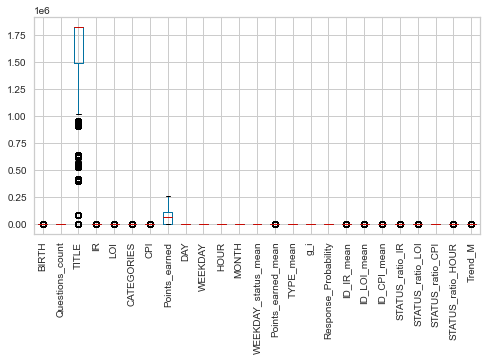

In [48]:
# 이상치 제거 전 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

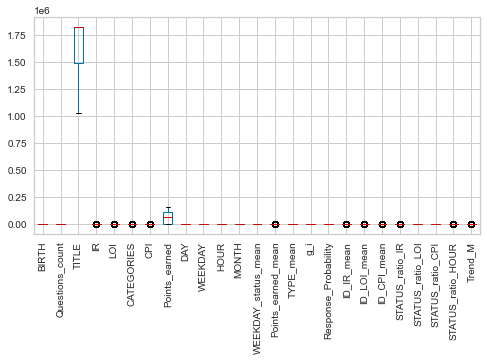

In [49]:
# 수치형 변수 이상치 제거
features[num] = features[num].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 이상치 제거 후 수치형 변수 시각화
plt.figure(figsize = (8, 4))
features[num].boxplot()
plt.xticks(fontsize = 10, rotation = 90)
plt.show()

In [50]:
#StandardScaler
from sklearn.preprocessing import StandardScaler

# 스케일링 전 train, test 분할
X_train = features.iloc[:y_train.shape[0], :]
X_test = features.iloc[y_train.shape[0]:, :]

scaler = StandardScaler()
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [51]:
# 원핫 인코딩
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

In [52]:
X_train.columns

Index(['BIRTH', 'Questions_count', 'TITLE', 'IR', 'LOI', 'CATEGORIES', 'CPI',
       'Points_earned', 'DAY', 'WEEKDAY', 'HOUR', 'MONTH',
       'WEEKDAY_status_mean', 'Points_earned_mean', 'TYPE_mean', 'g_i',
       'Response_Probability', 'ID_IR_mean', 'ID_LOI_mean', 'ID_CPI_mean',
       'STATUS_ratio_IR', 'STATUS_ratio_LOI', 'STATUS_ratio_CPI',
       'STATUS_ratio_HOUR', 'Trend_M', 'GENDER_1.0', 'GENDER_2.0', 'TYPE_B',
       'TYPE_C', 'TYPE_D'],
      dtype='object')

# 5. Feature Selection

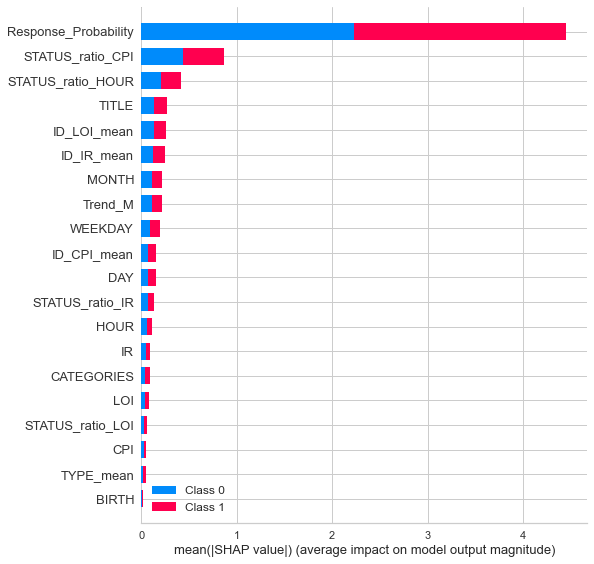

,column_name,shap_importance
16,Response_Probability,2.22554
22,STATUS_ratio_CPI,0.434951
23,STATUS_ratio_HOUR,0.209589
2,TITLE,0.137088
18,ID_LOI_mean,0.131715
17,ID_IR_mean,0.125134
11,MONTH,0.110577
24,Trend_M,0.110026
9,WEEKDAY,0.0985461
19,ID_CPI_mean,0.0764337


In [53]:
# Method: Using SHAP values 
import shap
from lightgbm import LGBMClassifier

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
model = LGBMClassifier(random_state=0).fit(X_train, y_train)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

# Plot summary_plot as barplot:
shap.summary_plot(shap_values, X_importance, plot_type='bar')

shap_sum = np.abs(shap_values).mean(axis=1)[1,:]
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

In [54]:
# feature 중요도가 0 이상
SHAP_THRESHOLD = 0
features_selected = importance_df.query('shap_importance > @SHAP_THRESHOLD').column_name.tolist()
X_train = X_train[features_selected]
X_test = X_test[features_selected]
print(X_train.shape)

(1217508, 26)


# Modeling

In [55]:
from lightgbm import LGBMClassifier

# 모델
lgbm_clf = LGBMClassifier(random_state = 20182817,  n_estimators=500)

In [56]:
lgbm_clf.fit(X_train, y_train, eval_set=[(X_train, y_train)], eval_metric = ['auc','logloss'], 
        verbose=True, early_stopping_rounds=10)

[1]	training's auc: 0.894318	training's binary_logloss: 0.640931
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.89603	training's binary_logloss: 0.603936
[3]	training's auc: 0.897708	training's binary_logloss: 0.573273
[4]	training's auc: 0.898365	training's binary_logloss: 0.547568
[5]	training's auc: 0.899284	training's binary_logloss: 0.525823
[6]	training's auc: 0.899751	training's binary_logloss: 0.507403
[7]	training's auc: 0.900139	training's binary_logloss: 0.491622
[8]	training's auc: 0.900409	training's binary_logloss: 0.478014
[9]	training's auc: 0.900877	training's binary_logloss: 0.466208
[10]	training's auc: 0.90119	training's binary_logloss: 0.456135
[11]	training's auc: 0.901487	training's binary_logloss: 0.447345
[12]	training's auc: 0.901955	training's binary_logloss: 0.439618
[13]	training's auc: 0.902245	training's binary_logloss: 0.432945
[14]	training's auc: 0.902581	training's binary_logloss: 0.427061
[15]	training's auc: 0.902

[125]	training's auc: 0.92651	training's binary_logloss: 0.342799
[126]	training's auc: 0.926585	training's binary_logloss: 0.342609
[127]	training's auc: 0.926621	training's binary_logloss: 0.342507
[128]	training's auc: 0.926651	training's binary_logloss: 0.342416
[129]	training's auc: 0.926702	training's binary_logloss: 0.342272
[130]	training's auc: 0.926828	training's binary_logloss: 0.342011
[131]	training's auc: 0.926906	training's binary_logloss: 0.341827
[132]	training's auc: 0.926931	training's binary_logloss: 0.341754
[133]	training's auc: 0.927001	training's binary_logloss: 0.341604
[134]	training's auc: 0.927046	training's binary_logloss: 0.341496
[135]	training's auc: 0.927183	training's binary_logloss: 0.341184
[136]	training's auc: 0.927242	training's binary_logloss: 0.341052
[137]	training's auc: 0.927297	training's binary_logloss: 0.340924
[138]	training's auc: 0.927324	training's binary_logloss: 0.340856
[139]	training's auc: 0.927404	training's binary_logloss: 0.340

[249]	training's auc: 0.93154	training's binary_logloss: 0.330508
[250]	training's auc: 0.931556	training's binary_logloss: 0.330473
[251]	training's auc: 0.931569	training's binary_logloss: 0.330439
[252]	training's auc: 0.931595	training's binary_logloss: 0.33038
[253]	training's auc: 0.931623	training's binary_logloss: 0.330314
[254]	training's auc: 0.931647	training's binary_logloss: 0.330261
[255]	training's auc: 0.931653	training's binary_logloss: 0.330238
[256]	training's auc: 0.931675	training's binary_logloss: 0.330179
[257]	training's auc: 0.931692	training's binary_logloss: 0.33014
[258]	training's auc: 0.931707	training's binary_logloss: 0.3301
[259]	training's auc: 0.931722	training's binary_logloss: 0.330066
[260]	training's auc: 0.931737	training's binary_logloss: 0.330034
[261]	training's auc: 0.931754	training's binary_logloss: 0.329992
[262]	training's auc: 0.9318	training's binary_logloss: 0.329882
[263]	training's auc: 0.931831	training's binary_logloss: 0.329815
[2

[373]	training's auc: 0.933945	training's binary_logloss: 0.324575
[374]	training's auc: 0.933971	training's binary_logloss: 0.324511
[375]	training's auc: 0.933978	training's binary_logloss: 0.324493
[376]	training's auc: 0.933983	training's binary_logloss: 0.324477
[377]	training's auc: 0.933996	training's binary_logloss: 0.324444
[378]	training's auc: 0.934009	training's binary_logloss: 0.324413
[379]	training's auc: 0.934019	training's binary_logloss: 0.324389
[380]	training's auc: 0.934035	training's binary_logloss: 0.324353
[381]	training's auc: 0.934049	training's binary_logloss: 0.324322
[382]	training's auc: 0.934059	training's binary_logloss: 0.324298
[383]	training's auc: 0.934071	training's binary_logloss: 0.324268
[384]	training's auc: 0.934087	training's binary_logloss: 0.324229
[385]	training's auc: 0.934103	training's binary_logloss: 0.324189
[386]	training's auc: 0.934113	training's binary_logloss: 0.324164
[387]	training's auc: 0.934132	training's binary_logloss: 0.32

[497]	training's auc: 0.935661	training's binary_logloss: 0.320355
[498]	training's auc: 0.935679	training's binary_logloss: 0.320302
[499]	training's auc: 0.935685	training's binary_logloss: 0.320283
[500]	training's auc: 0.9357	training's binary_logloss: 0.320243
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.9357	training's binary_logloss: 0.320243


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=20182817, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [57]:
lgbm_pred_proba = lgbm_clf.predict_proba(X_test)

In [60]:
pd.DataFrame({'ID':test_id["ID"], 'STATUS': lgbm_pred_proba[:,1]}).to_csv(os.path.abspath("./e_submission") + "/lgbm.csv", index=False)

In [ ]:
from sklearn.model_selection import KFold

In [59]:
from sklearn.ensemble import RandomForestClassifier

val_scores = []
rf_pred = np.zeros((X_test.shape[0]))


for trn_idx, val_idx in kf.split(X_train,y_train):
    
    X_tr, y_tr = X_train.iloc[trn_idx,:], y_train[trn_idx]
    X_val, y_val = X_train.iloc[val_idx,:], y_train[val_idx]

    clf = RandomForestClassifier(random_state = 20182817)
    
    clf.fit(X_tr,y_tr)
    
    val_score = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
    
    val_scores.append(val_score)
    
    rf_pred += clf.predict_proba(X_test)[:,1]
    
print('CV score : ', np.mean(val_scores))

CV score :  0.927435252327092


In [60]:
rf_pred = pd.DataFrame({'ID': test_id["ID"], 'STATUS': rf_pred/5})

In [72]:
rf_pred.to_csv(os.path.abspath("./e_submission") + "/rf_oof.csv", index=False)